In [1]:
import numpy as np
import pandas as pd
import gudhi

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from sklearn import datasets

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from urllib.request import urlopen
from urllib.parse import urlparse
import os.path

from pogo import Pogo

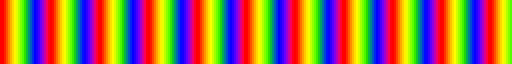

In [2]:
%matplotlib inline

cmap = plt.cm.get_cmap("prism").copy()
#cmap.set_bad(cmap(0))

cmap.set_under('white')
cmap.set_over('white')
cmap.set_bad("black")
#cmap(number_of_clusters)

cm.get_cmap(cmap)

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [3]:
#data from scikitlearn tutorial on clustering 

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), np.zeros(n_samples,dtype='int')

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [4]:
X=varied[0]
y=varied[1]
filename = 'varied'


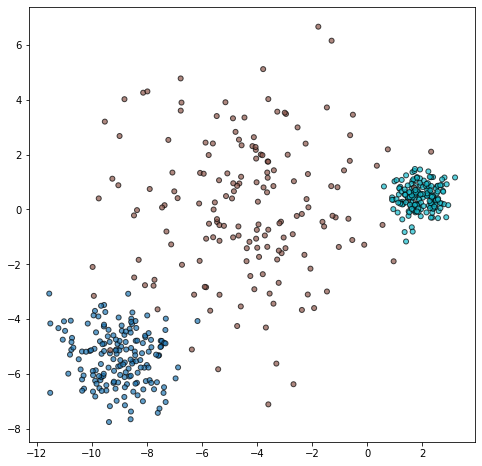

In [5]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [6]:
pogo = Pogo(overlapping=True)
pogo.fit(X)

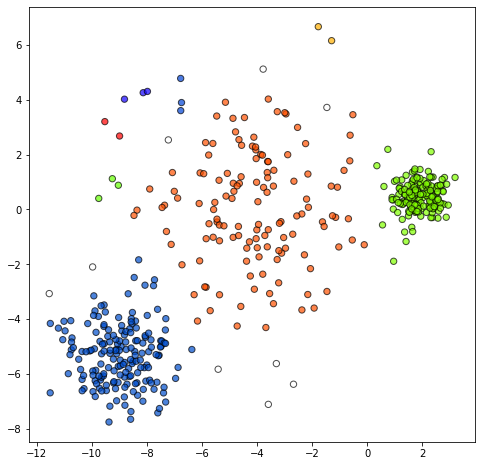

In [7]:
pogo.plot_diagram()

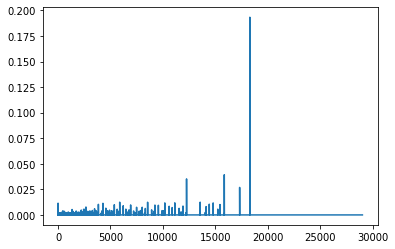

In [8]:
plt.plot(pogo.gap_vector_)

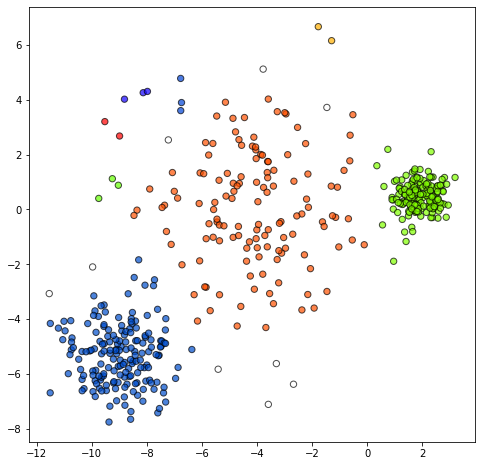

In [9]:
pogo.plot_diagram(pogo.candidates_[80])

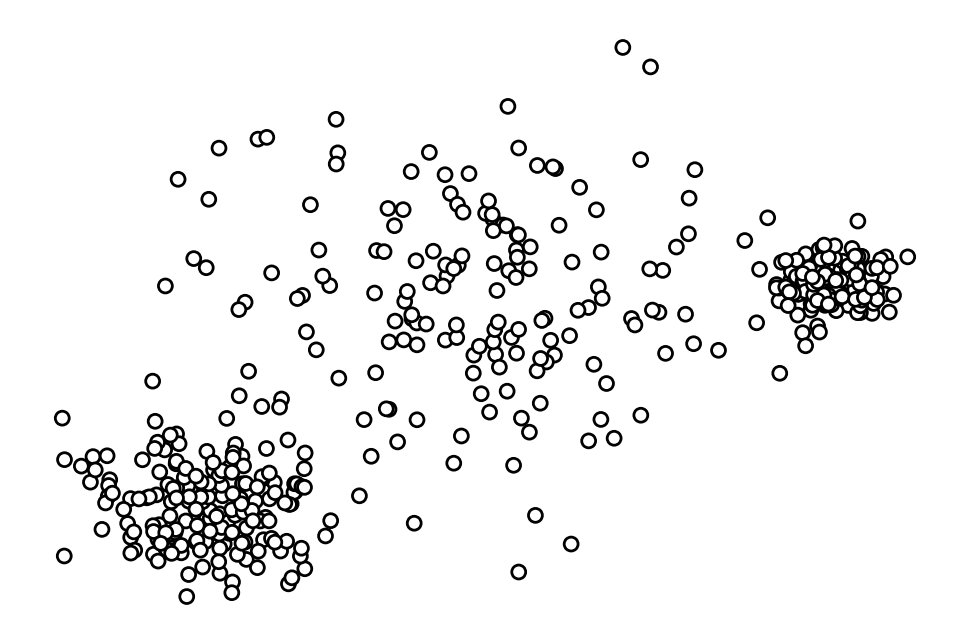

In [10]:
pogo.animate_pogo()

In [11]:
pogo.confidence_

'0.9%'

In [12]:
pogo.idx_

11921

In [13]:
pogo.initial_idx_

18297

In [14]:
pogo.candidates_[:10]

array([18297, 15860, 12260, 17325, 13559,  5883,  8546, 11139, 10186,
       14797])

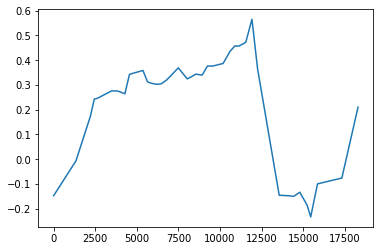

In [15]:
silhouete_indices, silhouette_array = pogo.plot_silhouette_score(40)

In [16]:
silhouette_array

array([-0.1476594 , -0.00738045,  0.17398071,  0.24254832,  0.24425307,
        0.24705744,  0.27584039,  0.27535326,  0.26406531,  0.34274478,
        0.3585573 ,  0.31228577,  0.30654507,  0.30221103,  0.30461018,
        0.3190373 ,  0.32896638,  0.36889395,  0.32440068,  0.3347471 ,
        0.34357975,  0.33962225,  0.37629752,  0.37633556,  0.3866727 ,
        0.43557833,  0.45716147,  0.45702861,  0.47214075,  0.56545108,
        0.36443736, -0.14606507, -0.14797337, -0.15058144, -0.13384926,
       -0.18622706, -0.23364298, -0.10014622, -0.07645297,  0.2100633 ])

(array([    2,  3849,  4283,  5369,  5883,  6221,  6926,  8546,  9244,
         9570, 10186, 11139, 12260, 13559, 14427, 14797, 15453, 15860,
        17325, 18297]),
 array([3.07687146e-04, 7.23296320e-01, 7.30392428e-01, 7.40551379e-01,
        7.73266451e-01, 7.73775955e-01, 7.71005812e-01, 7.81564705e-01,
        7.98044200e-01, 7.95133199e-01, 8.00760335e-01, 8.16621243e-01,
        5.26540115e-01, 2.79761820e-03, 2.74359045e-03, 1.90909234e-03,
        1.94212123e-03, 8.83782719e-04, 1.86474120e-04, 1.61930942e-05]))

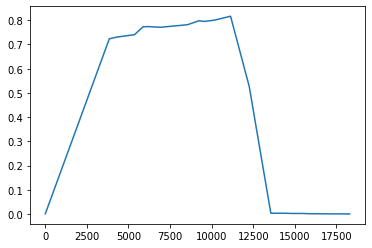

In [17]:
pogo.plot_rand_score(20,y)

In [ ]:
#silhouette reduce loop
current_silhouette_max = metrics.silhouette_score(X, np.array(list(pogo.cluster_dict_list_[pogo.candidates_[0]].values())), metric="euclidean")

for i in range(len(pogo.candidates_)):
    print(pogo.candidates_[i])
    print(current_silhouette_max)
    print(metrics.silhouette_score(X, np.array(list(pogo.cluster_dict_list_[pogo.candidates_[i]].values())), metric="euclidean"))

    while metrics.silhouette_score(X, np.array(list(pogo.cluster_dict_list_[pogo.candidates_[i]].values())), metric="euclidean") > metrics.silhouette_score(X, np.array(list(pogo.cluster_dict_list_[i].values())), metric="euclidean"):
        print(i)
        print(metrics.silhouette_score(X, np.array(list(pogo.cluster_dict_list_[pogo.candidates_[i]].values())), metric="euclidean"))
        idx = pogo.candidates_[i+1]

In [ ]:
true = y

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

In [ ]:
diag = pogo.simplex_tree_.persistence()
gudhi.plot_persistence_barcode(diag)
plt.show()

In [ ]:
pogo.simplex_tree_.num_simplices()

In [ ]:
#check that all clusters have merged
len(np.unique(pogo.candidates_[-1]))

In [ ]:
print(pogo.cluster_dict_list_[-2].values()) #penultimate clustering has 2 clusters
print(pogo.cluster_dict_list_[-1].values()) #last clustering finally merges to all one cluster

In [ ]:

print('your dataset appears to have', pogo.n_clusters_,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

In [ ]:
silhouette_array, idx_array = pogo.get_silhouette_array(10)

In [ ]:
plt.plot(idx_array,silhouette_array)

In [ ]:
print(pogo.idx_)

In [ ]:
print(pogo.initial_idx_)

In [ ]:
#DBSCAN Demo Data from scikitlearn
centers = [[1, 1], [-1, -1], [1, -1]]
X, y = datasets.make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)
filename = 'dbscan-demo-data'

In [ ]:

urls_with_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

urls_without_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/overlap.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/a1.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

ground_truth_urls = ['https://cs.joensuu.fi/sipu/datasets/overlap.pa'
    
]

urls_with_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_with_ground_truth
}


urls_without_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_without_ground_truth
}


ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in ground_truth_urls
}

In [ ]:
urls_with_ground_truth

In [ ]:
ground_truth

In [ ]:
def return_dataset(filename):
    if filename in urls_with_ground_truth:
        url= urls_with_ground_truth[filename]
        print(url)
        parse = urlparse(url)
        print(filename)
        raw_data = urlopen(url)
        data = np.loadtxt(raw_data)

        print(data.shape)
        print(data[:10])

        y = data[:,2]
        print(y.shape)
        X = data[:,:2]
        print(X.shape)
        return X, y, filename
    else:
        pass

In [ ]:
#X, y, filename = return_dataset('R15.txt')

In [ ]:
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target

In [ ]:
rand_score_list = []
true = y
for i in idx_list:
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [ ]:
rand_score_array = np.asarray(rand_score_list)

In [ ]:
plt.plot(idx_array,rand_score_array)

In [ ]:
max(rand_score_array)

In [ ]:
idx = idx_array[rand_score_array.argmax()]
idx

In [ ]:
pred = np.array(list(cluster_dict_list[idx].values()))
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

In [ ]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


cluster_dict_list, candidates, idx = pogo(X)

true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))
